# Federated Learning + Linear Quantization for RESNET18 & CIFAR10

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm
import seaborn as sns
from fedlern.utils import *
from fedlern.train_utils import *
from fedlern.quant_utils import *
from fedlern.models.resnet_v2 import ResNet18

## Relevant Parameters

In [5]:
epoch = 5
rounds = 25
num_clients = 10

clients_sample_size = int(.3 * num_clients) # Use 30% of available clients
num_workers = 8
train_batch_size =128
eval_batch_size=256
quantize_bits = 16
stats = (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)

## Data Loaders
- Divide the test & training data
- Divide the training data among the clients

In [6]:
 # Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# split the training data
train_splits = torch.utils.data.random_split(train_dataset, [int(train_dataset.data.shape[0]/num_clients) for i in range(num_clients)])

# Data loaders
train_loaders = [DataLoader(dataset=split, batch_size=train_batch_size, shuffle=True, num_workers=num_workers) for split in train_splits]
test_loader = DataLoader(dataset=test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified



- `server_aggregate` function aggregates the model weights received from every client and updates the global model with the updated weights.

In [7]:

def server_aggregate(global_model : torch.nn.Module, client_models):
    """
    The means of the weights of the client models are aggregated to the global model
    """
    global_dict = global_model.state_dict() # Get a copy of the global model state_dict
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_models[i].state_dict()[key].float() for i in range(len(client_models))],0).mean(0)
    global_model.load_state_dict(global_dict)
    
    # Update the client models using the global model
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

## Global & Clients instatiation
Implement the same elements as before, but:
- We need more instances of the model
- An optimizer for each model

In [8]:
global_model = ResNet18().to(device)
client_models = [ResNet18()
                     .to(device)
                     #.load_state_dict(global_model.state_dict())
                  for _ in range(num_clients)]



# criterion = nn.CrossEntropyLoss() # computes the cross-entropy loss between the predicted and true labels
# optimizers =[optim.Adam(model.parameters(), lr=0.001) for model in client_models]


In [9]:
# Optimizer & criterion based on gobal model
global_optimizer = get_model_optimizer(global_model,
                                       learning_rate=0.1,
                                       weight_decay=5e-4)

#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,120,160], gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device) # computes the cross-entropy loss between the predicted and true labels

optimizers = [get_model_optimizer(model,learning_rate=0.1, weight_decay=5e-4) for model in client_models]

In [10]:
# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for round in tqdm(range(rounds)):


    # Select n random clients
    selected_clients = np.random.permutation(num_clients)[:clients_sample_size]
    # Train the selected clients
    for client in selected_clients:
        # Individual criterion and optimizer

        train_loss, train_acc = qtrain_model(model = client_models[client],
                                             train_loader = train_loaders[client],
                                             device = device,
                                             criterion = criterion,
                                             optimizer = optimizers[client],
                                             num_epochs=epoch,
                                             bits = quantize_bits)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Aggregate
    server_aggregate(global_model, client_models)

    # Test the global model
    test_loss, test_acc = evaluate_model(model=global_model,
                                         test_loader=test_loader,
                                         device=device,
                                         criterion=criterion)

    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"{round}-th ROUND: average train loss {(train_loss / clients_sample_size):0.3g} | test loss {test_loss:0.3g} | test acc: {test_acc:0.3f}")
    
    

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0/5 Train Loss: 3.099 Train Acc: 0.143
Epoch: 1/5 Train Loss: 2.188 Train Acc: 0.207
Epoch: 2/5 Train Loss: 2.072 Train Acc: 0.225
Epoch: 3/5 Train Loss: 2.021 Train Acc: 0.254
Epoch: 4/5 Train Loss: 2.016 Train Acc: 0.264
Epoch: 0/5 Train Loss: 3.268 Train Acc: 0.130
Epoch: 1/5 Train Loss: 2.293 Train Acc: 0.188
Epoch: 2/5 Train Loss: 2.032 Train Acc: 0.234
Epoch: 3/5 Train Loss: 1.985 Train Acc: 0.238
Epoch: 4/5 Train Loss: 1.988 Train Acc: 0.242
Epoch: 0/5 Train Loss: 2.746 Train Acc: 0.185
Epoch: 1/5 Train Loss: 2.101 Train Acc: 0.238
Epoch: 2/5 Train Loss: 1.972 Train Acc: 0.251
Epoch: 3/5 Train Loss: 1.828 Train Acc: 0.303
Epoch: 4/5 Train Loss: 1.829 Train Acc: 0.305


  4%|▍         | 1/25 [01:17<30:58, 77.44s/it]

0-th ROUND: average train loss 0.61 | test loss 2.3 | test acc: 0.100
Epoch: 0/5 Train Loss: 2.307 Train Acc: 0.130
Epoch: 1/5 Train Loss: 2.220 Train Acc: 0.156
Epoch: 2/5 Train Loss: 2.187 Train Acc: 0.171
Epoch: 3/5 Train Loss: 2.183 Train Acc: 0.176
Epoch: 4/5 Train Loss: 2.181 Train Acc: 0.174
Epoch: 0/5 Train Loss: 2.128 Train Acc: 0.184
Epoch: 1/5 Train Loss: 2.128 Train Acc: 0.211
Epoch: 2/5 Train Loss: 1.939 Train Acc: 0.270
Epoch: 3/5 Train Loss: 1.850 Train Acc: 0.309
Epoch: 4/5 Train Loss: 1.830 Train Acc: 0.317
Epoch: 0/5 Train Loss: 2.125 Train Acc: 0.203
Epoch: 1/5 Train Loss: 2.036 Train Acc: 0.232
Epoch: 2/5 Train Loss: 1.888 Train Acc: 0.286
Epoch: 3/5 Train Loss: 1.800 Train Acc: 0.319
Epoch: 4/5 Train Loss: 1.789 Train Acc: 0.326


  8%|▊         | 2/25 [02:29<28:26, 74.19s/it]

1-th ROUND: average train loss 0.596 | test loss 2.31 | test acc: 0.123
Epoch: 0/5 Train Loss: 2.079 Train Acc: 0.209
Epoch: 1/5 Train Loss: 2.038 Train Acc: 0.243
Epoch: 2/5 Train Loss: 2.022 Train Acc: 0.258
Epoch: 3/5 Train Loss: 2.017 Train Acc: 0.258
Epoch: 4/5 Train Loss: 2.018 Train Acc: 0.255
Epoch: 0/5 Train Loss: 2.033 Train Acc: 0.235
Epoch: 1/5 Train Loss: 2.059 Train Acc: 0.213
Epoch: 2/5 Train Loss: 1.890 Train Acc: 0.279
Epoch: 3/5 Train Loss: 1.821 Train Acc: 0.318
Epoch: 4/5 Train Loss: 1.808 Train Acc: 0.324
Epoch: 0/5 Train Loss: 2.082 Train Acc: 0.224
Epoch: 1/5 Train Loss: 2.039 Train Acc: 0.245
Epoch: 2/5 Train Loss: 2.015 Train Acc: 0.264
Epoch: 3/5 Train Loss: 2.014 Train Acc: 0.262
Epoch: 4/5 Train Loss: 2.010 Train Acc: 0.270


 12%|█▏        | 3/25 [03:41<26:49, 73.14s/it]

2-th ROUND: average train loss 0.67 | test loss 2.31 | test acc: 0.100
Epoch: 0/5 Train Loss: 1.976 Train Acc: 0.249
Epoch: 1/5 Train Loss: 1.951 Train Acc: 0.259
Epoch: 2/5 Train Loss: 1.826 Train Acc: 0.308
Epoch: 3/5 Train Loss: 1.756 Train Acc: 0.330
Epoch: 4/5 Train Loss: 1.757 Train Acc: 0.337
Epoch: 0/5 Train Loss: 1.965 Train Acc: 0.267
Epoch: 1/5 Train Loss: 1.938 Train Acc: 0.278
Epoch: 2/5 Train Loss: 1.926 Train Acc: 0.295
Epoch: 3/5 Train Loss: 1.919 Train Acc: 0.295
Epoch: 4/5 Train Loss: 1.921 Train Acc: 0.294
Epoch: 0/5 Train Loss: 1.982 Train Acc: 0.245
Epoch: 1/5 Train Loss: 1.980 Train Acc: 0.253
Epoch: 2/5 Train Loss: 1.982 Train Acc: 0.249
Epoch: 3/5 Train Loss: 1.980 Train Acc: 0.251
Epoch: 4/5 Train Loss: 1.978 Train Acc: 0.256


 16%|█▌        | 4/25 [04:53<25:25, 72.63s/it]

3-th ROUND: average train loss 0.659 | test loss 2.32 | test acc: 0.100
Epoch: 0/5 Train Loss: 1.901 Train Acc: 0.306
Epoch: 1/5 Train Loss: 1.877 Train Acc: 0.304
Epoch: 2/5 Train Loss: 1.872 Train Acc: 0.311
Epoch: 3/5 Train Loss: 1.874 Train Acc: 0.308
Epoch: 4/5 Train Loss: 1.873 Train Acc: 0.315
Epoch: 0/5 Train Loss: 1.905 Train Acc: 0.295
Epoch: 1/5 Train Loss: 1.905 Train Acc: 0.292
Epoch: 2/5 Train Loss: 1.909 Train Acc: 0.285
Epoch: 3/5 Train Loss: 1.909 Train Acc: 0.287
Epoch: 4/5 Train Loss: 1.905 Train Acc: 0.296
Epoch: 0/5 Train Loss: 1.892 Train Acc: 0.301
Epoch: 1/5 Train Loss: 1.876 Train Acc: 0.311
Epoch: 2/5 Train Loss: 1.862 Train Acc: 0.313
Epoch: 3/5 Train Loss: 1.864 Train Acc: 0.316
Epoch: 4/5 Train Loss: 1.865 Train Acc: 0.308


 20%|██        | 5/25 [06:04<24:07, 72.35s/it]

4-th ROUND: average train loss 0.622 | test loss 2.33 | test acc: 0.100
Epoch: 0/5 Train Loss: 1.899 Train Acc: 0.295
Epoch: 1/5 Train Loss: 1.901 Train Acc: 0.295
Epoch: 2/5 Train Loss: 1.898 Train Acc: 0.297
Epoch: 3/5 Train Loss: 1.896 Train Acc: 0.293
Epoch: 4/5 Train Loss: 1.905 Train Acc: 0.290
Epoch: 0/5 Train Loss: 1.903 Train Acc: 0.297
Epoch: 1/5 Train Loss: 1.884 Train Acc: 0.304
Epoch: 2/5 Train Loss: 1.874 Train Acc: 0.307
Epoch: 3/5 Train Loss: 1.881 Train Acc: 0.303
Epoch: 4/5 Train Loss: 1.879 Train Acc: 0.304
Epoch: 0/5 Train Loss: 1.906 Train Acc: 0.292
Epoch: 1/5 Train Loss: 1.904 Train Acc: 0.294
Epoch: 2/5 Train Loss: 1.906 Train Acc: 0.292
Epoch: 3/5 Train Loss: 1.909 Train Acc: 0.287
Epoch: 4/5 Train Loss: 1.907 Train Acc: 0.283


 24%|██▍       | 6/25 [07:16<22:52, 72.23s/it]

5-th ROUND: average train loss 0.636 | test loss 2.34 | test acc: 0.100
Epoch: 0/5 Train Loss: 1.892 Train Acc: 0.309
Epoch: 1/5 Train Loss: 1.895 Train Acc: 0.301
Epoch: 2/5 Train Loss: 1.896 Train Acc: 0.301
Epoch: 3/5 Train Loss: 1.897 Train Acc: 0.304
Epoch: 4/5 Train Loss: 1.901 Train Acc: 0.297
Epoch: 0/5 Train Loss: 1.944 Train Acc: 0.269
Epoch: 1/5 Train Loss: 1.919 Train Acc: 0.270
Epoch: 2/5 Train Loss: 1.834 Train Acc: 0.311
Epoch: 3/5 Train Loss: 1.745 Train Acc: 0.349
Epoch: 4/5 Train Loss: 1.738 Train Acc: 0.349
Epoch: 0/5 Train Loss: 1.897 Train Acc: 0.296
Epoch: 1/5 Train Loss: 1.894 Train Acc: 0.303
Epoch: 2/5 Train Loss: 1.898 Train Acc: 0.296
Epoch: 3/5 Train Loss: 1.898 Train Acc: 0.295
Epoch: 4/5 Train Loss: 1.897 Train Acc: 0.293


 28%|██▊       | 7/25 [08:28<21:37, 72.10s/it]

6-th ROUND: average train loss 0.632 | test loss 2.37 | test acc: 0.100
Epoch: 0/5 Train Loss: 1.867 Train Acc: 0.321
Epoch: 1/5 Train Loss: 1.867 Train Acc: 0.315
Epoch: 2/5 Train Loss: 1.866 Train Acc: 0.313
Epoch: 3/5 Train Loss: 1.864 Train Acc: 0.315
Epoch: 4/5 Train Loss: 1.866 Train Acc: 0.323
Epoch: 0/5 Train Loss: 1.852 Train Acc: 0.314
Epoch: 1/5 Train Loss: 1.847 Train Acc: 0.321
Epoch: 2/5 Train Loss: 1.849 Train Acc: 0.319
Epoch: 3/5 Train Loss: 1.855 Train Acc: 0.310
Epoch: 4/5 Train Loss: 1.856 Train Acc: 0.319
Epoch: 0/5 Train Loss: 1.855 Train Acc: 0.311
Epoch: 1/5 Train Loss: 1.855 Train Acc: 0.307
Epoch: 2/5 Train Loss: 1.859 Train Acc: 0.317
Epoch: 3/5 Train Loss: 1.855 Train Acc: 0.307
Epoch: 4/5 Train Loss: 1.854 Train Acc: 0.312


 32%|███▏      | 8/25 [09:40<20:25, 72.07s/it]

7-th ROUND: average train loss 0.618 | test loss 2.39 | test acc: 0.100
Epoch: 0/5 Train Loss: 1.853 Train Acc: 0.315
Epoch: 1/5 Train Loss: 1.848 Train Acc: 0.312
Epoch: 2/5 Train Loss: 1.853 Train Acc: 0.318
Epoch: 3/5 Train Loss: 1.852 Train Acc: 0.323
Epoch: 4/5 Train Loss: 1.848 Train Acc: 0.315
Epoch: 0/5 Train Loss: 1.864 Train Acc: 0.306
Epoch: 1/5 Train Loss: 1.861 Train Acc: 0.306
Epoch: 2/5 Train Loss: 1.861 Train Acc: 0.311
Epoch: 3/5 Train Loss: 1.864 Train Acc: 0.309
Epoch: 4/5 Train Loss: 1.861 Train Acc: 0.306
Epoch: 0/5 Train Loss: 1.844 Train Acc: 0.319
Epoch: 1/5 Train Loss: 1.845 Train Acc: 0.319
Epoch: 2/5 Train Loss: 1.846 Train Acc: 0.317
Epoch: 3/5 Train Loss: 1.852 Train Acc: 0.313
Epoch: 4/5 Train Loss: 1.846 Train Acc: 0.317


 36%|███▌      | 9/25 [10:52<19:12, 72.03s/it]

8-th ROUND: average train loss 0.615 | test loss 2.38 | test acc: 0.124
Epoch: 0/5 Train Loss: 1.862 Train Acc: 0.315
Epoch: 1/5 Train Loss: 1.854 Train Acc: 0.311
Epoch: 2/5 Train Loss: 1.857 Train Acc: 0.315
Epoch: 3/5 Train Loss: 1.855 Train Acc: 0.311
Epoch: 4/5 Train Loss: 1.857 Train Acc: 0.312
Epoch: 0/5 Train Loss: 1.856 Train Acc: 0.320
Epoch: 1/5 Train Loss: 1.846 Train Acc: 0.333
Epoch: 2/5 Train Loss: 1.837 Train Acc: 0.325
Epoch: 3/5 Train Loss: 1.836 Train Acc: 0.335
Epoch: 4/5 Train Loss: 1.836 Train Acc: 0.324
Epoch: 0/5 Train Loss: 1.851 Train Acc: 0.318
Epoch: 1/5 Train Loss: 1.850 Train Acc: 0.315
Epoch: 2/5 Train Loss: 1.851 Train Acc: 0.311
Epoch: 3/5 Train Loss: 1.849 Train Acc: 0.314
Epoch: 4/5 Train Loss: 1.849 Train Acc: 0.321


 40%|████      | 10/25 [12:04<18:00, 72.02s/it]

9-th ROUND: average train loss 0.616 | test loss 2.34 | test acc: 0.134
Epoch: 0/5 Train Loss: 1.864 Train Acc: 0.317
Epoch: 1/5 Train Loss: 1.868 Train Acc: 0.312
Epoch: 2/5 Train Loss: 1.866 Train Acc: 0.316
Epoch: 3/5 Train Loss: 1.870 Train Acc: 0.318
Epoch: 4/5 Train Loss: 1.866 Train Acc: 0.312
Epoch: 0/5 Train Loss: 1.848 Train Acc: 0.315
Epoch: 1/5 Train Loss: 1.853 Train Acc: 0.311
Epoch: 2/5 Train Loss: 1.855 Train Acc: 0.311
Epoch: 3/5 Train Loss: 1.851 Train Acc: 0.313
Epoch: 4/5 Train Loss: 1.852 Train Acc: 0.315
Epoch: 0/5 Train Loss: 1.919 Train Acc: 0.277
Epoch: 1/5 Train Loss: 2.008 Train Acc: 0.248
Epoch: 2/5 Train Loss: 1.907 Train Acc: 0.278
Epoch: 3/5 Train Loss: 1.782 Train Acc: 0.341
Epoch: 4/5 Train Loss: 1.776 Train Acc: 0.334


 44%|████▍     | 11/25 [13:16<16:47, 72.00s/it]

10-th ROUND: average train loss 0.592 | test loss 2.29 | test acc: 0.127
Epoch: 0/5 Train Loss: 1.836 Train Acc: 0.322
Epoch: 1/5 Train Loss: 1.843 Train Acc: 0.319
Epoch: 2/5 Train Loss: 1.842 Train Acc: 0.319
Epoch: 3/5 Train Loss: 1.840 Train Acc: 0.320
Epoch: 4/5 Train Loss: 1.841 Train Acc: 0.316
Epoch: 0/5 Train Loss: 1.843 Train Acc: 0.310
Epoch: 1/5 Train Loss: 1.846 Train Acc: 0.316
Epoch: 2/5 Train Loss: 1.842 Train Acc: 0.309
Epoch: 3/5 Train Loss: 1.843 Train Acc: 0.317
Epoch: 4/5 Train Loss: 1.849 Train Acc: 0.308
Epoch: 0/5 Train Loss: 1.859 Train Acc: 0.309
Epoch: 1/5 Train Loss: 1.858 Train Acc: 0.303
Epoch: 2/5 Train Loss: 1.864 Train Acc: 0.305
Epoch: 3/5 Train Loss: 1.861 Train Acc: 0.307
Epoch: 4/5 Train Loss: 1.863 Train Acc: 0.300


 48%|████▊     | 12/25 [14:28<15:35, 71.98s/it]

11-th ROUND: average train loss 0.621 | test loss 2.2 | test acc: 0.183
Epoch: 0/5 Train Loss: 1.842 Train Acc: 0.317
Epoch: 1/5 Train Loss: 1.835 Train Acc: 0.314
Epoch: 2/5 Train Loss: 1.844 Train Acc: 0.314
Epoch: 3/5 Train Loss: 1.846 Train Acc: 0.317
Epoch: 4/5 Train Loss: 1.839 Train Acc: 0.319
Epoch: 0/5 Train Loss: 1.851 Train Acc: 0.326
Epoch: 1/5 Train Loss: 1.853 Train Acc: 0.317
Epoch: 2/5 Train Loss: 1.853 Train Acc: 0.321
Epoch: 3/5 Train Loss: 1.849 Train Acc: 0.317
Epoch: 4/5 Train Loss: 1.845 Train Acc: 0.322
Epoch: 0/5 Train Loss: 1.848 Train Acc: 0.306
Epoch: 1/5 Train Loss: 1.852 Train Acc: 0.312
Epoch: 2/5 Train Loss: 1.855 Train Acc: 0.313
Epoch: 3/5 Train Loss: 1.856 Train Acc: 0.308
Epoch: 4/5 Train Loss: 1.848 Train Acc: 0.313


 52%|█████▏    | 13/25 [15:40<14:23, 71.98s/it]

12-th ROUND: average train loss 0.616 | test loss 2.1 | test acc: 0.235
Epoch: 0/5 Train Loss: 1.839 Train Acc: 0.315
Epoch: 1/5 Train Loss: 1.843 Train Acc: 0.315
Epoch: 2/5 Train Loss: 1.842 Train Acc: 0.307
Epoch: 3/5 Train Loss: 1.847 Train Acc: 0.313
Epoch: 4/5 Train Loss: 1.841 Train Acc: 0.318
Epoch: 0/5 Train Loss: 1.852 Train Acc: 0.300
Epoch: 1/5 Train Loss: 1.850 Train Acc: 0.310
Epoch: 2/5 Train Loss: 1.853 Train Acc: 0.309
Epoch: 3/5 Train Loss: 1.850 Train Acc: 0.311
Epoch: 4/5 Train Loss: 1.854 Train Acc: 0.304
Epoch: 0/5 Train Loss: 1.852 Train Acc: 0.318
Epoch: 1/5 Train Loss: 1.847 Train Acc: 0.321
Epoch: 2/5 Train Loss: 1.849 Train Acc: 0.319
Epoch: 3/5 Train Loss: 1.848 Train Acc: 0.320
Epoch: 4/5 Train Loss: 1.853 Train Acc: 0.318


 56%|█████▌    | 14/25 [16:52<13:12, 72.00s/it]

13-th ROUND: average train loss 0.618 | test loss 2.01 | test acc: 0.273
Epoch: 0/5 Train Loss: 1.863 Train Acc: 0.310
Epoch: 1/5 Train Loss: 1.861 Train Acc: 0.311
Epoch: 2/5 Train Loss: 1.858 Train Acc: 0.311
Epoch: 3/5 Train Loss: 1.860 Train Acc: 0.307
Epoch: 4/5 Train Loss: 1.860 Train Acc: 0.302
Epoch: 0/5 Train Loss: 1.847 Train Acc: 0.310
Epoch: 1/5 Train Loss: 1.852 Train Acc: 0.304
Epoch: 2/5 Train Loss: 1.851 Train Acc: 0.310
Epoch: 3/5 Train Loss: 1.853 Train Acc: 0.311
Epoch: 4/5 Train Loss: 1.850 Train Acc: 0.305
Epoch: 0/5 Train Loss: 1.840 Train Acc: 0.319
Epoch: 1/5 Train Loss: 1.838 Train Acc: 0.310
Epoch: 2/5 Train Loss: 1.838 Train Acc: 0.321
Epoch: 3/5 Train Loss: 1.839 Train Acc: 0.315
Epoch: 4/5 Train Loss: 1.838 Train Acc: 0.314


 60%|██████    | 15/25 [18:04<12:00, 72.01s/it]

14-th ROUND: average train loss 0.613 | test loss 1.93 | test acc: 0.299
Epoch: 0/5 Train Loss: 1.842 Train Acc: 0.314
Epoch: 1/5 Train Loss: 1.840 Train Acc: 0.312
Epoch: 2/5 Train Loss: 1.841 Train Acc: 0.315
Epoch: 3/5 Train Loss: 1.841 Train Acc: 0.311
Epoch: 4/5 Train Loss: 1.840 Train Acc: 0.317
Epoch: 0/5 Train Loss: 1.916 Train Acc: 0.291
Epoch: 1/5 Train Loss: 1.887 Train Acc: 0.291
Epoch: 2/5 Train Loss: 1.784 Train Acc: 0.335
Epoch: 3/5 Train Loss: 1.673 Train Acc: 0.381
Epoch: 4/5 Train Loss: 1.656 Train Acc: 0.382
Epoch: 0/5 Train Loss: 1.854 Train Acc: 0.308
Epoch: 1/5 Train Loss: 1.848 Train Acc: 0.314
Epoch: 2/5 Train Loss: 1.851 Train Acc: 0.319
Epoch: 3/5 Train Loss: 1.853 Train Acc: 0.314
Epoch: 4/5 Train Loss: 1.850 Train Acc: 0.313


 64%|██████▍   | 16/25 [19:16<10:47, 71.99s/it]

15-th ROUND: average train loss 0.617 | test loss 1.94 | test acc: 0.302
Epoch: 0/5 Train Loss: 1.819 Train Acc: 0.334
Epoch: 1/5 Train Loss: 1.823 Train Acc: 0.332
Epoch: 2/5 Train Loss: 1.818 Train Acc: 0.332
Epoch: 3/5 Train Loss: 1.818 Train Acc: 0.325
Epoch: 4/5 Train Loss: 1.820 Train Acc: 0.328
Epoch: 0/5 Train Loss: 1.821 Train Acc: 0.327
Epoch: 1/5 Train Loss: 1.831 Train Acc: 0.332
Epoch: 2/5 Train Loss: 1.825 Train Acc: 0.330
Epoch: 3/5 Train Loss: 1.826 Train Acc: 0.328
Epoch: 4/5 Train Loss: 1.824 Train Acc: 0.330
Epoch: 0/5 Train Loss: 1.805 Train Acc: 0.331
Epoch: 1/5 Train Loss: 1.810 Train Acc: 0.325
Epoch: 2/5 Train Loss: 1.805 Train Acc: 0.327
Epoch: 3/5 Train Loss: 1.813 Train Acc: 0.329
Epoch: 4/5 Train Loss: 1.810 Train Acc: 0.331


 68%|██████▊   | 17/25 [20:28<09:35, 71.96s/it]

16-th ROUND: average train loss 0.603 | test loss 1.88 | test acc: 0.321
Epoch: 0/5 Train Loss: 1.816 Train Acc: 0.315
Epoch: 1/5 Train Loss: 1.814 Train Acc: 0.322
Epoch: 2/5 Train Loss: 1.815 Train Acc: 0.323
Epoch: 3/5 Train Loss: 1.813 Train Acc: 0.323
Epoch: 4/5 Train Loss: 1.813 Train Acc: 0.323
Epoch: 0/5 Train Loss: 1.818 Train Acc: 0.318
Epoch: 1/5 Train Loss: 1.825 Train Acc: 0.315
Epoch: 2/5 Train Loss: 1.817 Train Acc: 0.320
Epoch: 3/5 Train Loss: 1.820 Train Acc: 0.329
Epoch: 4/5 Train Loss: 1.819 Train Acc: 0.319
Epoch: 0/5 Train Loss: 1.808 Train Acc: 0.323
Epoch: 1/5 Train Loss: 1.811 Train Acc: 0.326
Epoch: 2/5 Train Loss: 1.810 Train Acc: 0.330
Epoch: 3/5 Train Loss: 1.808 Train Acc: 0.320
Epoch: 4/5 Train Loss: 1.806 Train Acc: 0.330


 72%|███████▏  | 18/25 [21:40<08:23, 71.98s/it]

17-th ROUND: average train loss 0.602 | test loss 1.84 | test acc: 0.335
Epoch: 0/5 Train Loss: 1.818 Train Acc: 0.322
Epoch: 1/5 Train Loss: 1.817 Train Acc: 0.322
Epoch: 2/5 Train Loss: 1.814 Train Acc: 0.325
Epoch: 3/5 Train Loss: 1.816 Train Acc: 0.322
Epoch: 4/5 Train Loss: 1.822 Train Acc: 0.326
Epoch: 0/5 Train Loss: 1.818 Train Acc: 0.325
Epoch: 1/5 Train Loss: 1.818 Train Acc: 0.330
Epoch: 2/5 Train Loss: 1.811 Train Acc: 0.336
Epoch: 3/5 Train Loss: 1.801 Train Acc: 0.338
Epoch: 4/5 Train Loss: 1.804 Train Acc: 0.335
Epoch: 0/5 Train Loss: 1.812 Train Acc: 0.321
Epoch: 1/5 Train Loss: 1.816 Train Acc: 0.321
Epoch: 2/5 Train Loss: 1.818 Train Acc: 0.321
Epoch: 3/5 Train Loss: 1.809 Train Acc: 0.321
Epoch: 4/5 Train Loss: 1.814 Train Acc: 0.322


 76%|███████▌  | 19/25 [22:52<07:11, 71.96s/it]

18-th ROUND: average train loss 0.605 | test loss 1.81 | test acc: 0.345
Epoch: 0/5 Train Loss: 1.829 Train Acc: 0.323
Epoch: 1/5 Train Loss: 1.819 Train Acc: 0.327
Epoch: 2/5 Train Loss: 1.822 Train Acc: 0.331
Epoch: 3/5 Train Loss: 1.823 Train Acc: 0.329
Epoch: 4/5 Train Loss: 1.831 Train Acc: 0.326
Epoch: 0/5 Train Loss: 1.813 Train Acc: 0.325
Epoch: 1/5 Train Loss: 1.820 Train Acc: 0.321
Epoch: 2/5 Train Loss: 1.818 Train Acc: 0.322
Epoch: 3/5 Train Loss: 1.819 Train Acc: 0.328
Epoch: 4/5 Train Loss: 1.811 Train Acc: 0.331
Epoch: 0/5 Train Loss: 1.827 Train Acc: 0.321
Epoch: 1/5 Train Loss: 1.831 Train Acc: 0.316
Epoch: 2/5 Train Loss: 1.835 Train Acc: 0.315
Epoch: 3/5 Train Loss: 1.833 Train Acc: 0.309
Epoch: 4/5 Train Loss: 1.832 Train Acc: 0.314


 80%|████████  | 20/25 [24:04<05:59, 71.99s/it]

19-th ROUND: average train loss 0.611 | test loss 1.8 | test acc: 0.348
Epoch: 0/5 Train Loss: 1.812 Train Acc: 0.325
Epoch: 1/5 Train Loss: 1.811 Train Acc: 0.326
Epoch: 2/5 Train Loss: 1.811 Train Acc: 0.328
Epoch: 3/5 Train Loss: 1.805 Train Acc: 0.330
Epoch: 4/5 Train Loss: 1.807 Train Acc: 0.335
Epoch: 0/5 Train Loss: 1.819 Train Acc: 0.332
Epoch: 1/5 Train Loss: 1.819 Train Acc: 0.322
Epoch: 2/5 Train Loss: 1.817 Train Acc: 0.332
Epoch: 3/5 Train Loss: 1.817 Train Acc: 0.322
Epoch: 4/5 Train Loss: 1.820 Train Acc: 0.331
Epoch: 0/5 Train Loss: 1.813 Train Acc: 0.337
Epoch: 1/5 Train Loss: 1.804 Train Acc: 0.341
Epoch: 2/5 Train Loss: 1.798 Train Acc: 0.340
Epoch: 3/5 Train Loss: 1.804 Train Acc: 0.340
Epoch: 4/5 Train Loss: 1.802 Train Acc: 0.340


 84%|████████▍ | 21/25 [25:16<04:47, 71.99s/it]

20-th ROUND: average train loss 0.601 | test loss 1.79 | test acc: 0.347
Epoch: 0/5 Train Loss: 1.812 Train Acc: 0.327
Epoch: 1/5 Train Loss: 1.808 Train Acc: 0.328
Epoch: 2/5 Train Loss: 1.814 Train Acc: 0.324
Epoch: 3/5 Train Loss: 1.814 Train Acc: 0.320
Epoch: 4/5 Train Loss: 1.812 Train Acc: 0.325
Epoch: 0/5 Train Loss: 1.805 Train Acc: 0.335
Epoch: 1/5 Train Loss: 1.812 Train Acc: 0.322
Epoch: 2/5 Train Loss: 1.803 Train Acc: 0.326
Epoch: 3/5 Train Loss: 1.810 Train Acc: 0.333
Epoch: 4/5 Train Loss: 1.806 Train Acc: 0.326
Epoch: 0/5 Train Loss: 1.819 Train Acc: 0.328
Epoch: 1/5 Train Loss: 1.819 Train Acc: 0.333
Epoch: 2/5 Train Loss: 1.816 Train Acc: 0.343
Epoch: 3/5 Train Loss: 1.818 Train Acc: 0.334
Epoch: 4/5 Train Loss: 1.812 Train Acc: 0.330


 88%|████████▊ | 22/25 [26:28<03:35, 71.96s/it]

21-th ROUND: average train loss 0.604 | test loss 1.79 | test acc: 0.343
Epoch: 0/5 Train Loss: 1.821 Train Acc: 0.326
Epoch: 1/5 Train Loss: 1.827 Train Acc: 0.327
Epoch: 2/5 Train Loss: 1.818 Train Acc: 0.334
Epoch: 3/5 Train Loss: 1.824 Train Acc: 0.323
Epoch: 4/5 Train Loss: 1.820 Train Acc: 0.330
Epoch: 0/5 Train Loss: 1.807 Train Acc: 0.322
Epoch: 1/5 Train Loss: 1.809 Train Acc: 0.325
Epoch: 2/5 Train Loss: 1.807 Train Acc: 0.327
Epoch: 3/5 Train Loss: 1.815 Train Acc: 0.322
Epoch: 4/5 Train Loss: 1.801 Train Acc: 0.335
Epoch: 0/5 Train Loss: 1.812 Train Acc: 0.327
Epoch: 1/5 Train Loss: 1.814 Train Acc: 0.319
Epoch: 2/5 Train Loss: 1.809 Train Acc: 0.324
Epoch: 3/5 Train Loss: 1.814 Train Acc: 0.324
Epoch: 4/5 Train Loss: 1.811 Train Acc: 0.323


 92%|█████████▏| 23/25 [27:40<02:23, 71.96s/it]

22-th ROUND: average train loss 0.604 | test loss 1.79 | test acc: 0.343
Epoch: 0/5 Train Loss: 1.805 Train Acc: 0.327
Epoch: 1/5 Train Loss: 1.801 Train Acc: 0.334
Epoch: 2/5 Train Loss: 1.808 Train Acc: 0.327
Epoch: 3/5 Train Loss: 1.803 Train Acc: 0.326
Epoch: 4/5 Train Loss: 1.809 Train Acc: 0.337
Epoch: 0/5 Train Loss: 1.827 Train Acc: 0.318
Epoch: 1/5 Train Loss: 1.832 Train Acc: 0.314
Epoch: 2/5 Train Loss: 1.826 Train Acc: 0.318
Epoch: 3/5 Train Loss: 1.831 Train Acc: 0.322
Epoch: 4/5 Train Loss: 1.827 Train Acc: 0.315
Epoch: 0/5 Train Loss: 1.822 Train Acc: 0.326
Epoch: 1/5 Train Loss: 1.818 Train Acc: 0.335
Epoch: 2/5 Train Loss: 1.808 Train Acc: 0.346
Epoch: 3/5 Train Loss: 1.817 Train Acc: 0.336
Epoch: 4/5 Train Loss: 1.811 Train Acc: 0.331


 96%|█████████▌| 24/25 [28:52<01:11, 71.97s/it]

23-th ROUND: average train loss 0.604 | test loss 1.79 | test acc: 0.341
Epoch: 0/5 Train Loss: 1.805 Train Acc: 0.327
Epoch: 1/5 Train Loss: 1.804 Train Acc: 0.328
Epoch: 2/5 Train Loss: 1.799 Train Acc: 0.329
Epoch: 3/5 Train Loss: 1.808 Train Acc: 0.330
Epoch: 4/5 Train Loss: 1.805 Train Acc: 0.330
Epoch: 0/5 Train Loss: 1.819 Train Acc: 0.332
Epoch: 1/5 Train Loss: 1.819 Train Acc: 0.339
Epoch: 2/5 Train Loss: 1.818 Train Acc: 0.333
Epoch: 3/5 Train Loss: 1.819 Train Acc: 0.331
Epoch: 4/5 Train Loss: 1.819 Train Acc: 0.336
Epoch: 0/5 Train Loss: 1.809 Train Acc: 0.324
Epoch: 1/5 Train Loss: 1.817 Train Acc: 0.321
Epoch: 2/5 Train Loss: 1.820 Train Acc: 0.323
Epoch: 3/5 Train Loss: 1.806 Train Acc: 0.329
Epoch: 4/5 Train Loss: 1.812 Train Acc: 0.328


100%|██████████| 25/25 [30:04<00:00, 72.17s/it]

24-th ROUND: average train loss 0.604 | test loss 1.79 | test acc: 0.340


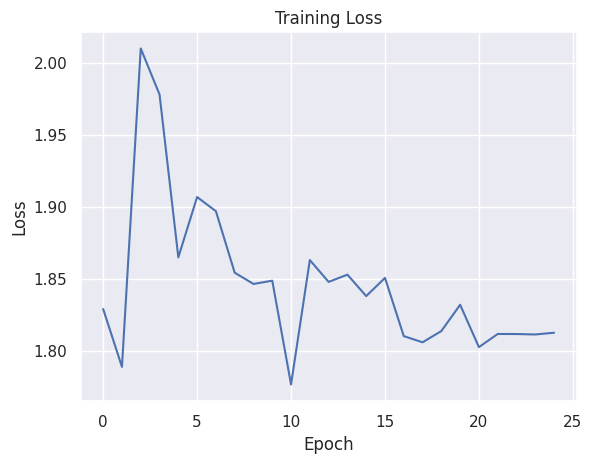

In [11]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
train_accs = [d.item() for d in train_accs]
test_accs = [d.item() for d in test_accs]

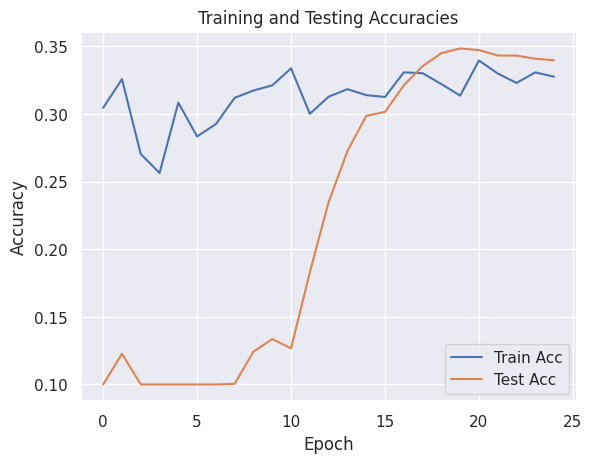

In [13]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = evaluate_model(global_model, test_loader, device,)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 0.0, Accuracy: 33.97999954223633%
44.77 MB
CPU Inference Latency: 7.75 ms / sample
CUDA Inference Latency: 2.93 ms / sample


In [15]:
save_model(global_model, "saved_models", f'resnet_fedlern_{quantize_bits}bits_{time_stamp()}.pth')

In [16]:
pass